In [1]:
import os
import subprocess
import time

import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18
from copy import deepcopy
import torch.nn.functional as F
from sklearn import linear_model, model_selection
from sklearn.metrics import make_scorer, accuracy_score
from tqdm.notebook import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

from typing import Callable

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(42)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 
DEVICE

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Running on device: CUDA


'cuda'

In [2]:
torch.manual_seed(3047)

Gr = torch.Generator()
Gr.manual_seed(20)

Gf = torch.Generator()
Gf.manual_seed(30)

Gv = torch.Generator()
Gv.manual_seed(40)

In [3]:
# Mock setting

import logging
import requests
import tqdm
from torch.utils.data import Subset
from torchvision import transforms

USE_MOCK: bool = True

if USE_MOCK:
    logging.warning('Running with Mock')
    logging.warning('In this mode, internet access may be required.')

    # The number of checkpoints in this mode.
    # NOTE: 512 checkpoints are required in this competition.
    n_checkpoints = 10
    
    # The directory for a dataset and a pretrained model
    mock_dir = './mock'
    mock_model_path = os.path.join(mock_dir, "weights_resnet18_cifar10.pth")
    os.makedirs(mock_dir, exist_ok=True)

In [4]:
# It's really important to add an accelerator to your notebook, as otherwise the submission will fail.
# We recomment using the P100 GPU rather than T4 as it's faster and will increase the chances of passing the time cut-off threshold.

if DEVICE != 'cuda':
    raise RuntimeError('Make sure you have added an accelerator to your notebook; the submission will fail otherwise!')

In [5]:
local_path = "retrain_weights_resnet18_cifar10.pth"
if os.path.exists(local_path):
    os.remove(local_path)

In [6]:
response = requests.get("https://storage.googleapis.com/unlearning-challenge/" + local_path)
open(local_path, "wb").write(response.content)

44808169

In [7]:
weights_pretrained = torch.load(local_path, map_location=DEVICE)

# load model with pre-trained weights
rt_model = resnet18(weights=None, num_classes=10)
rt_model.load_state_dict(weights_pretrained)
rt_model.to(DEVICE)
rt_model.eval()

# print its accuracy on retain and forget set
# print(f"Retain set accuracy: {100.0 * accuracy(rt_model, retain_loader):0.1f}%")
# print(f"Forget set accuracy: {100.0 * accuracy(rt_model, forget_loader):0.1f}%")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
# # Helper functions for loading the hidden dataset.

# if USE_MOCK:
    
#     class DatasetWrapper(Dataset):
        
#         def __init__(self, ds: Dataset):
#             self._ds = ds
    
#         def __len__(self):
#             return len(self._ds)
    
#         def __getitem__(self, index):
#             item = self._ds[index]
#             result = {
#                 'image': item[0],
#                 'image_id': index,
#                 'age_group': item[1],
#                 'age': item[1],
#                 'person_id': index,
#             }
#             return result
    
#     def get_dataset(batch_size, retain_ratio=0.98, thinning_param: int=1, root=mock_dir) -> tuple[DataLoader, DataLoader, DataLoader]:
        
#         # utils
#         normalize = transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
#         ])

#         # create dataset
#         train_ds = DatasetWrapper(torchvision.datasets.CIFAR10(root=mock_dir, train=True, download=True, transform=normalize))
#         retain_ds = Subset(train_ds, range(0, int(len(train_ds)*retain_ratio), thinning_param))
#         forget_ds = Subset(train_ds, range(int(len(train_ds)*retain_ratio), len(train_ds), thinning_param))
#         val_ds = DatasetWrapper(torchvision.datasets.CIFAR10(root=mock_dir, train=False, download=True, transform=normalize))

#         retain_loader = DataLoader(retain_ds, batch_size=batch_size, shuffle=True)
#         forget_loader = DataLoader(forget_ds, batch_size=batch_size, shuffle=True)
#         validation_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)

#         return retain_loader, forget_loader, validation_loader
    
#     # For test
# #     for sample in get_dataset(3)[0]:
# #         print(sample)
# #         break
    
# else:
#     def load_example(df_row):
#         image = torchvision.io.read_image(df_row['image_path'])
#         result = {
#             'image': image,
#             'image_id': df_row['image_id'],
#             'age_group': df_row['age_group'],
#             'age': df_row['age'],
#             'person_id': df_row['person_id']
#         }
#         return result


#     class HiddenDataset(Dataset):
#         '''The hidden dataset.'''
#         def __init__(self, split='train'):
#             super().__init__()
#             self.examples = []

#             df = pd.read_csv(f'/kaggle/input/neurips-2023-machine-unlearning/{split}.csv')
#             df['image_path'] = df['image_id'].apply(lambda x: os.path.join('/kaggle/input/neurips-2023-machine-unlearning/', 'images', x.split('-')[0], x.split('-')[1] + '.png'))
#             df = df.sort_values(by='image_path')
#             df.apply(lambda row: self.examples.append(load_example(row)), axis=1)
#             if len(self.examples) == 0:
#                 raise ValueError('No examples.')

#         def __len__(self):
#             return len(self.examples)

#         def __getitem__(self, idx):
#             example = self.examples[idx]
#             image = example['image']
#             image = image.to(torch.float32)
#             example['image'] = image
#             return example


#     def get_dataset(batch_size):
#         '''Get the dataset.'''
#         retain_ds = HiddenDataset(split='retain')
#         forget_ds = HiddenDataset(split='forget')
#         val_ds = HiddenDataset(split='validation')

#         retain_loader = DataLoader(retain_ds, batch_size=batch_size, shuffle=True, generator=Gr)
#         forget_loader = DataLoader(forget_ds, batch_size=batch_size, shuffle=True, generator=Gf)
#         validation_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, generator=Gv)
#         #retain_loader = DataLoader(retain_ds, batch_size=batch_size, shuffle=True)
#         #forget_loader = DataLoader(forget_ds, batch_size=batch_size, shuffle=True)
#         #validation_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)

#         return retain_loader, forget_loader, validation_loader

In [9]:
# download and pre-process CIFAR10
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=normalize
)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

# we split held out data into test and validation set
held_out = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=normalize
)
test_set, val_set = torch.utils.data.random_split(held_out, [0.5, 0.5], generator=RNG)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)

# download the forget and retain index split
local_path = "forget_idx.npy"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/" + local_path
    )
    open(local_path, "wb").write(response.content)
forget_idx = np.load(local_path)

# construct indices of retain from those of the forget set
forget_mask = np.zeros(len(train_set.targets), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]

# split train set into a forget and a retain set
forget_set = torch.utils.data.Subset(train_set, forget_idx)
retain_set = torch.utils.data.Subset(train_set, retain_idx)

forget_loader = torch.utils.data.DataLoader(
    forget_set, batch_size=128, shuffle=True, num_workers=2
)
retain_loader = torch.utils.data.DataLoader(
    retain_set, batch_size=128, shuffle=True, num_workers=2, generator=RNG
)

100%|██████████| 170498071/170498071 [00:04<00:00, 35253517.56it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [10]:
# # Utils
# from contextlib import contextmanager
# import time

# @contextmanager
# def stopwatch(name='STOPWATCH'):
#     s = time.time()
#     try:
#         yield
#     finally:
#         print(f"{name}: {time.time()-s} seconds passed")
        
# # for test
# # with stopwatch():
# #     for i in range(5):
# #         time.sleep(1)

In [11]:
from torch.optim.lr_scheduler import CosineAnnealingLR,CosineAnnealingWarmRestarts,StepLR
def kl_loss_sym(x,y):
    kl_loss = nn.KLDivLoss(reduction='batchmean')
    return kl_loss(nn.LogSoftmax(dim=-1)(x),y)
def unlearning(
        net,
        retain_loader,
        forget_loader,
        val_loader,
):
    """Simple unlearning by finetuning."""
    print('-----------------------------------')
    epochs = 8
    retain_bs = 256
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=0)
    optimizer_retain = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_retain, T_max=5)
#     ##the learning rate is associated with the batchsize we used
    optimizer_forget = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
#     total_step = int(len(forget_loader)*epochs)
#     retain_ld = DataLoader(retain_loader.dataset, batch_size=retain_bs, shuffle=True)
#     retain_ld4fgt = DataLoader(retain_loader.dataset, batch_size=256, shuffle=True)
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
#     if USE_MOCK: ##Use some Local Metric as reference
#         net.eval()
#         print('Forget')
#         evaluation(net, forget_loader, criterion)
#         print('Valid')
#         evaluation(net, val_loader, criterion)
    net.train()
    for _ in range(10):
        for inputs,target in forget_loader: ##First Stage 
    #         inputs = sample["image"]
            inputs = inputs.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(inputs)
            uniform_label = torch.ones_like(outputs).to(DEVICE) / outputs.shape[1] ##uniform pseudo label
            loss = kl_loss_sym(outputs, uniform_label) ##optimize the distance between logits and pseudo labels
            loss.backward()
            optimizer.step()
# #     if USE_MOCK:
# #         print('Forget')
# #         evaluation(net,forget_loader,criterion)
# #         print('Valid')
# #         evaluation(net, val_loader,criterion)
# #         print(f'epoch={epochs} and retain batch_sz={retain_bs}')
    net.train()
    for ep in range(8): ##Second Stage 
        for (inputs_forget,targets_forget), (inputs_retain,targets_retain) in zip(forget_loader, retain_loader):##Forget Round
            t = 1.15 ##temperature coefficient
            inputs_forget, inputs_retain = inputs_forget.to(DEVICE), inputs_retain.to(DEVICE)
            optimizer_forget.zero_grad()
            outputs_forget = net(inputs_forget)
            outputs_retain = net(inputs_retain)
            loss = (-1 * nn.LogSoftmax(dim=-1)(outputs_forget @ outputs_retain.T/t)).mean() ##Contrastive Learning loss
            loss.backward()
            optimizer_forget.step()
    for _ in range(8):
        for (inputs, labels) in retain_loader: ##Retain Round
#             inputs, labels = sample["image"],sample["age_group"]
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer_retain.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer_retain.step()
        scheduler.step()
    if USE_MOCK: 
#         print(f'epoch {ep}:')
        print('Retain')
        evaluation(net, retain_loader, criterion)
        print('Forget')
        evaluation(net, forget_loader, criterion)
        print('Valid')
        evaluation(net, val_loader, criterion)
    print('-----------------------------------')
    return net

In [12]:
def evaluation(net, dataloader, criterion, device = 'cuda'): ##evaluation function
    net.eval()
    total_samp = 0
    total_acc = 0
    total_loss = 0.0
    for (images, labels) in dataloader:
        images, labels = images.to(device), labels.to(device)
        _pred = net(images)
        total_samp+=len(labels)
        #print(f'total_samp={total_samp}')
        loss = criterion(_pred, labels)
        total_loss += loss.item()
        total_acc+=(_pred.max(1)[1] == labels).float().sum().item()
        #print(f'total_acc={total_acc}')
    #print(f'total_sample={total_samp}')
    mean_loss = total_loss / len(dataloader)
    mean_acc = total_acc/total_samp
    print(f'loss={mean_loss}')
    print(f'acc={mean_acc}')
    return mean_acc, mean_loss

In [13]:
criterion = nn.CrossEntropyLoss()
# retain_loader, forget_loader, validation_loader = get_dataset(64)
print(f"Retain set accuracy: {100.0 * evaluation(rt_model, retain_loader, criterion)[0]:0.1f}%")
print(f"Forget set accuracy: {100.0 * evaluation(rt_model, forget_loader, criterion)[0]:0.1f}%")

loss=0.01812899909815645
acc=0.9952666666666666
Retain set accuracy: 99.5%
loss=0.47970084361732007
acc=0.882
Forget set accuracy: 88.2%


In [14]:
def compute_outputs(net, loader):
    """Auxiliary function to compute the logits for all datapoints.
    Does not shuffle the data, regardless of the loader.
    """

    # Make sure loader does not shuffle the data
    if isinstance(loader.sampler, torch.utils.data.sampler.RandomSampler):
        loader = DataLoader(
            loader.dataset, 
            batch_size=loader.batch_size, 
            shuffle=False, 
            num_workers=loader.num_workers)
    
    all_outputs = []
    all_targets = []
    
    for (inputs, targets) in loader:
#         inputs, targets = sample["image"],sample["age_group"]
        inputs, targets = inputs.to(DEVICE), targets.to("cpu")

        logits = net(inputs).detach().cpu().numpy() # (batch_size, num_classes)
        
        all_outputs.append(logits)
        all_targets.extend(targets)
        
    return np.array(all_targets), np.concatenate(all_outputs) # (len(loader.dataset), num_classes)
    

In [15]:
def cross_entropy_f(x, targets):
    # Convert NumPy array to PyTorch tensor
    x_tensor = torch.from_numpy(x)

    # Apply softmax to the model output
    x_softmax = F.softmax(x_tensor, dim=-1)

    # Convert targets to one-hot encoding
    targets_tensor = torch.from_numpy(targets)
    targets_one_hot = F.one_hot(targets_tensor, num_classes=x_tensor.shape[-1])

    # Avoiding NaN values in x
    x_tensor[torch.isnan(x_tensor)] = 0.0

    # Calculate cross-entropy loss for each example
    loss = -torch.sum(targets_one_hot * torch.log(x_softmax), dim=-1)

    # Convert the result back to a NumPy array if needed
    loss_np = loss.numpy()

    return loss_np

In [16]:
def false_positive_rate(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Computes the false positive rate (FPR)."""
    fp = np.sum(np.logical_and((y_pred == 1), (y_true == 0)))
    n = np.sum(y_true == 0)
    return fp / n


def false_negative_rate(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Computes the false negative rate (FNR)."""
    fn = np.sum(np.logical_and((y_pred == 0), (y_true == 1)))
    p = np.sum(y_true == 1)
    return fn / p


# The SCORING dictionary is used by sklearn's `cross_validate` function so that
# we record the FPR and FNR metrics of interest when doing cross validation
SCORING = {
    'false_positive_rate': make_scorer(false_positive_rate),
    'false_negative_rate': make_scorer(false_negative_rate)
}


def logistic_regression_attack(
        outputs_U, outputs_R, n_splits=2, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      outputs_U: numpy array of shape (N)
      outputs_R: numpy array of shape (N)
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      fpr, fnr : float * float
    """
    assert len(outputs_U) == len(outputs_R)
    
    samples = np.concatenate((outputs_R, outputs_U)).reshape((-1, 1))
    labels = np.array([0] * len(outputs_R) + [1] * len(outputs_U))

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    has_nan = np.isnan(samples).any()
#     print(has_nan)
    
    samples = np.nan_to_num(samples, nan=0)
    
    scores =  model_selection.cross_validate(
        attack_model, samples, labels, cv=cv, scoring=SCORING)
    
    fpr = np.mean(scores["test_false_positive_rate"])
    fnr = np.mean(scores["test_false_negative_rate"])
    
    return fpr, fnr

In [17]:
def compute_epsilon_s(fpr: list[float], fnr: list[float], delta: float) -> float:
    """Computes the privacy degree (epsilon) of a particular forget set example, 
    given the FPRs and FNRs resulting from various attacks.
    
    The smaller epsilon is, the better the unlearning is.
    
    Args:
      fpr: list[float] of length m = num attacks. The FPRs for a particular example. 
      fnr: list[float] of length m = num attacks. The FNRs for a particular example.
      delta: float
    Returns:
      epsilon: float corresponding to the privacy degree of the particular example.
    """
    assert len(fpr) == len(fnr)
    
    per_attack_epsilon = [0.]
    for fpr_i, fnr_i in zip(fpr, fnr):
        if fpr_i == 0 and fnr_i == 0:
            per_attack_epsilon.append(np.inf)
        elif fpr_i == 0 or fnr_i == 0:
            pass # discard attack
        else:
            with np.errstate(invalid='ignore'):
                epsilon1 = np.log(1. - delta - fpr_i) - np.log(fnr_i)
                epsilon2 = np.log(1. - delta - fnr_i) - np.log(fpr_i)
            if np.isnan(epsilon1) and np.isnan(epsilon2):
                per_attack_epsilon.append(np.inf)
            else:
                per_attack_epsilon.append(np.nanmax([epsilon1, epsilon2]))
            
    return np.nanmax(per_attack_epsilon)


def bin_index_fn(
        epsilons: np.ndarray, 
        bin_width: float = 0.5, 
        B: int = 13
        ) -> np.ndarray:
    """The bin index function."""
    bins = np.arange(0, B) * bin_width
    return np.digitize(epsilons, bins)


def H(epsilons: np.ndarray) -> float:
    """Computes the forgetting quality given the privacy degrees 
    of the forget set examples.
    """
    ns = bin_index_fn(epsilons)
    hs = 2. / 2 ** ns
    return np.mean(hs)

In [18]:
def forgetting_quality(
        outputs_U: np.ndarray, # (N, S)
        outputs_R: np.ndarray, # (N, S)
        attacks: list[Callable] = [logistic_regression_attack],
        delta: float = 0.01
    ):
    """
    Both `outputs_U` and `outputs_R` are of numpy arrays of ndim 2:
    * 1st dimension coresponds to the number of samples obtained from the 
      distribution of each model (N=512 in the case of the competition's leaderboard) 
    * 2nd dimension corresponds to the number of samples in the forget set (S).
    """
    
    # N = number of model samples
    # S = number of forget samples
    N, S = outputs_U.shape
    
    assert outputs_U.shape == outputs_R.shape, \
        "unlearn and retrain outputs need to be of the same shape"
    
    epsilons = []
    pbar = tqdm(range(S))
    for sample_id in pbar:
        pbar.set_description("Computing F...")
        
        sample_fprs, sample_fnrs = [], []
        
        for attack in attacks: 
            uls = outputs_U[:, sample_id]
            rls = outputs_R[:, sample_id]
            
            fpr, fnr = attack(uls, rls)
            
            if isinstance(fpr, list):
                sample_fprs.extend(fpr)
                sample_fnrs.extend(fnr)
            else:
                sample_fprs.append(fpr)
                sample_fnrs.append(fnr)
        
        sample_epsilon = compute_epsilon_s(sample_fprs, sample_fnrs, delta=delta)
        epsilons.append(sample_epsilon)
        
    return H(np.array(epsilons))

In [19]:
n_checkpoints

10

In [20]:
attacks = [logistic_regression_attack]
criterion = nn.CrossEntropyLoss()
outputs_U = []
outputs_R = []
retain_accuracy = []
test_accuracy = []
forget_accuracy = []

import numpy as np
if USE_MOCK:
    
    # NOTE: Almost same as the original codes
    
    # Download
    if not os.path.exists(mock_model_path):
        response = requests.get("https://storage.googleapis.com/unlearning-challenge/weights_resnet18_cifar10.pth")
        open(mock_model_path, "wb").write(response.content)    
    
    os.makedirs('/kaggle/tmp', exist_ok=True)
#     retain_loader, forget_loader, validation_loader = get_dataset(64)
    net = resnet18(weights=None, num_classes=10)
    net.to(DEVICE)
    net.load_state_dict(torch.load(mock_model_path))
    u_model = deepcopy(net)
    
    all_start = time.time()
    
    for i in tqdm.trange(n_checkpoints):
        net.load_state_dict(torch.load(mock_model_path))
        print("I am unlearning all the wrong things you taught me")
        
        start_time = time.time()
        
        u_model = unlearning(net, retain_loader, forget_loader, val_loader)
        
        end_time = time.time()
        
        training_time = end_time - start_time
        print(f'Training time for {i+1} epoch: {round(training_time, 2)} seconds ({round(training_time/60, 2)} minutes)')
        
        state = u_model.state_dict()
        torch.save(state, f'/kaggle/tmp/unlearned_checkpoint_{i}.pth')
        
        targets, outputs_Ui = compute_outputs(u_model, forget_loader)
        
        outputs_U.append( cross_entropy_f(outputs_Ui, targets) )
        
        print("Computing retain accuracy on Unlearning Model")
        acc, _ = evaluation(u_model, retain_loader, criterion)
        print("Retain accuracy on Unlearning Model is ",acc)
        retain_accuracy.append(acc)
        
        print("Computing test accuracy on Unlearning model")
        acc,_ = evaluation(u_model, val_loader, criterion)
        print("Test accuracy on Unlearning model is ", acc)
        test_accuracy.append(acc)
        
        print("Computing forget accuracy on Unlearning model")
        acc,_ = evaluation(u_model, forget_loader, criterion)
        print("Forget accuracy on Unlearning model is ",acc)
        forget_accuracy.append(acc)
    
    all_end = time.time()
    total_training_time = all_end - all_start
    print(f'Total Training time: {round(total_training_time, 2)} seconds ({round(total_training_time/60, 2)} minutes)')
    
    outputs_U = np.array(outputs_U)
    print("Printing outputs_U shape ",outputs_U.shape)
    
    assert outputs_U.shape == (n_checkpoints, len(forget_loader.dataset)),\
        "Wrong shape for outputs_U. Should be (num_model_samples, num_forget_datapoints)."
    
    
    RAR, _ = evaluation(rt_model, retain_loader, criterion)
    TAR, _ = evaluation(rt_model, val_loader, criterion)
    FAR, _ = evaluation(rt_model, forget_loader, criterion)
    
    RAU = np.mean(retain_accuracy)
    TAU = np.mean(test_accuracy)
    FAU = np.mean(forget_accuracy)
    
    RA_ratio = RAU / RAR
    TA_ratio = TAU / TAR
    
    for i in range(n_checkpoints):
        targets, outputs_Ri = compute_outputs(rt_model, forget_loader) #(len(forget_loader.dataset), 10) 
        
        outputs_R.append(cross_entropy_f(outputs_Ri, targets) )
    
    outputs_R = np.array(outputs_R)
    print("Printing outputs_R shape ",outputs_R.shape)
    

    
    # Ensure that submission.zip will contain exactly 512 checkpoints 
    # (if this is not the case, an exception will be thrown).
    unlearned_ckpts = os.listdir('/kaggle/tmp')
    if len(unlearned_ckpts) != n_checkpoints:
        raise RuntimeError('Expected exactly 512 checkpoints. The submission will throw an exception otherwise.')

    subprocess.run('zip submission.zip /kaggle/tmp/*.pth', shell=True)
    
    
else:
    print("Hi")


  0%|          | 0/10 [00:00<?, ?it/s]

I am unlearning all the wrong things you taught me
-----------------------------------
Retain
loss=0.017779857889929026
acc=0.9983333333333333
Forget
loss=0.301805689703906
acc=0.9044
Valid
loss=0.5471520654857158
acc=0.853
-----------------------------------
Training time for 1 epoch: 242.65 seconds (4.04 minutes)
Computing retain accuracy on Unlearning Model
loss=0.017765860259797508
acc=0.9983333333333333
Retain accuracy on Unlearning Model is  0.9983333333333333
Computing test accuracy on Unlearning model
loss=0.5471520654857158
acc=0.853
Test accuracy on Unlearning model is  0.853
Computing forget accuracy on Unlearning model


 10%|█         | 1/10 [04:12<37:54, 252.75s/it]

loss=0.31022180840373037
acc=0.9044
Forget accuracy on Unlearning model is  0.9044
I am unlearning all the wrong things you taught me
-----------------------------------
Retain
loss=0.01708151915094773
acc=0.9981555555555556
Forget
loss=0.3165020514279604
acc=0.909
Valid
loss=0.5329194858670234
acc=0.856
-----------------------------------
Training time for 2 epoch: 241.25 seconds (4.02 minutes)
Computing retain accuracy on Unlearning Model
loss=0.01707100983185228
acc=0.9981555555555556
Retain accuracy on Unlearning Model is  0.9981555555555556
Computing test accuracy on Unlearning model
loss=0.5329194858670234
acc=0.856
Test accuracy on Unlearning model is  0.856
Computing forget accuracy on Unlearning model


 20%|██        | 2/10 [08:24<33:35, 251.89s/it]

loss=0.3041145043447614
acc=0.909
Forget accuracy on Unlearning model is  0.909
I am unlearning all the wrong things you taught me
-----------------------------------
Retain
loss=0.02473262710687281
acc=0.9959333333333333
Forget
loss=0.3159622799605131
acc=0.9042
Valid
loss=0.5095584727823734
acc=0.8586
-----------------------------------
Training time for 3 epoch: 241.22 seconds (4.02 minutes)
Computing retain accuracy on Unlearning Model
loss=0.0247619531609499
acc=0.9959333333333333
Retain accuracy on Unlearning Model is  0.9959333333333333
Computing test accuracy on Unlearning model
loss=0.5095584727823734
acc=0.8586
Test accuracy on Unlearning model is  0.8586
Computing forget accuracy on Unlearning model


 30%|███       | 3/10 [12:35<29:21, 251.64s/it]

loss=0.30479938501375725
acc=0.9042
Forget accuracy on Unlearning model is  0.9042
I am unlearning all the wrong things you taught me
-----------------------------------
Retain
loss=0.028689370024949312
acc=0.9945333333333334
Forget
loss=0.3261703783646226
acc=0.9
Valid
loss=0.5318725273013115
acc=0.8498
-----------------------------------
Training time for 4 epoch: 241.06 seconds (4.02 minutes)
Computing retain accuracy on Unlearning Model
loss=0.028759204943939534
acc=0.9945333333333334
Retain accuracy on Unlearning Model is  0.9945333333333334
Computing test accuracy on Unlearning model
loss=0.5318725273013115
acc=0.8498
Test accuracy on Unlearning model is  0.8498
Computing forget accuracy on Unlearning model


 40%|████      | 4/10 [16:46<25:07, 251.32s/it]

loss=0.32791198380291464
acc=0.9
Forget accuracy on Unlearning model is  0.9
I am unlearning all the wrong things you taught me
-----------------------------------
Retain
loss=0.026385942899981852
acc=0.9959111111111111
Forget
loss=0.291420310921967
acc=0.9078
Valid
loss=0.5238622337579727
acc=0.8594
-----------------------------------
Training time for 5 epoch: 240.82 seconds (4.01 minutes)
Computing retain accuracy on Unlearning Model
loss=0.026369822835973042
acc=0.9959111111111111
Retain accuracy on Unlearning Model is  0.9959111111111111
Computing test accuracy on Unlearning model
loss=0.5238622337579727
acc=0.8594
Test accuracy on Unlearning model is  0.8594
Computing forget accuracy on Unlearning model


 50%|█████     | 5/10 [20:56<20:55, 251.05s/it]

loss=0.2979520082473755
acc=0.9078
Forget accuracy on Unlearning model is  0.9078
I am unlearning all the wrong things you taught me
-----------------------------------
Retain
loss=0.15993808332661336
acc=0.9508
Forget
loss=0.47605404555797576
acc=0.847
Valid
loss=0.5813286751508713
acc=0.811
-----------------------------------
Training time for 6 epoch: 240.82 seconds (4.01 minutes)
Computing retain accuracy on Unlearning Model
loss=0.15998463491401213
acc=0.9508
Retain accuracy on Unlearning Model is  0.9508
Computing test accuracy on Unlearning model
loss=0.5813286751508713
acc=0.811
Test accuracy on Unlearning model is  0.811
Computing forget accuracy on Unlearning model


 60%|██████    | 6/10 [25:07<16:43, 250.87s/it]

loss=0.46405021138489244
acc=0.847
Forget accuracy on Unlearning model is  0.847
I am unlearning all the wrong things you taught me
-----------------------------------
Retain
loss=0.15537250173193487
acc=0.9529777777777778
Forget
loss=0.5043574646115303
acc=0.8346
Valid
loss=0.6026808634400368
acc=0.8152
-----------------------------------
Training time for 7 epoch: 240.5 seconds (4.01 minutes)
Computing retain accuracy on Unlearning Model
loss=0.15548303208991207
acc=0.9529777777777778
Retain accuracy on Unlearning Model is  0.9529777777777778
Computing test accuracy on Unlearning model
loss=0.6026808634400368
acc=0.8152
Test accuracy on Unlearning model is  0.8152
Computing forget accuracy on Unlearning model


 70%|███████   | 7/10 [29:17<12:32, 250.79s/it]

loss=0.49904656745493414
acc=0.8346
Forget accuracy on Unlearning model is  0.8346
I am unlearning all the wrong things you taught me
-----------------------------------
Retain
loss=0.0169698335719824
acc=0.9984888888888889
Forget
loss=0.2596476200036705
acc=0.9192
Valid
loss=0.5044402502477169
acc=0.8608
-----------------------------------
Training time for 8 epoch: 240.85 seconds (4.01 minutes)
Computing retain accuracy on Unlearning Model
loss=0.016970035366036675
acc=0.9984888888888889
Retain accuracy on Unlearning Model is  0.9984888888888889
Computing test accuracy on Unlearning model
loss=0.5044402502477169
acc=0.8608
Test accuracy on Unlearning model is  0.8608
Computing forget accuracy on Unlearning model


 80%|████████  | 8/10 [33:28<08:21, 250.80s/it]

loss=0.3028014412149787
acc=0.9192
Forget accuracy on Unlearning model is  0.9192
I am unlearning all the wrong things you taught me
-----------------------------------
Retain
loss=0.041652080584423275
acc=0.9910888888888889
Forget
loss=0.35925481654703617
acc=0.8866
Valid
loss=0.525536298006773
acc=0.8532
-----------------------------------
Training time for 9 epoch: 241.09 seconds (4.02 minutes)
Computing retain accuracy on Unlearning Model
loss=0.04164493622639301
acc=0.9910888888888889
Retain accuracy on Unlearning Model is  0.9910888888888889
Computing test accuracy on Unlearning model
loss=0.525536298006773
acc=0.8532
Test accuracy on Unlearning model is  0.8532
Computing forget accuracy on Unlearning model


 90%|█████████ | 9/10 [37:39<04:10, 250.89s/it]

loss=0.3625823464244604
acc=0.8866
Forget accuracy on Unlearning model is  0.8866
I am unlearning all the wrong things you taught me
-----------------------------------
Retain
loss=0.023576710042437877
acc=0.9962666666666666
Forget
loss=0.2795980567112565
acc=0.9122
Valid
loss=0.5256787210702896
acc=0.8574
-----------------------------------
Training time for 10 epoch: 241.79 seconds (4.03 minutes)
Computing retain accuracy on Unlearning Model
loss=0.02359271702483635
acc=0.9962666666666666
Retain accuracy on Unlearning Model is  0.9962666666666666
Computing test accuracy on Unlearning model
loss=0.5256787210702896
acc=0.8574
Test accuracy on Unlearning model is  0.8574
Computing forget accuracy on Unlearning model


100%|██████████| 10/10 [41:51<00:00, 251.17s/it]

loss=0.27745325951837
acc=0.9122
Forget accuracy on Unlearning model is  0.9122
Total Training time: 2511.71 seconds (41.86 minutes)
Printing outputs_U shape  (10, 5000)


loss=0.018122820565291808
acc=0.9952666666666666
loss=0.4761434979736805
acc=0.8798
loss=0.4532230106124189
acc=0.882
Printing outputs_R shape  (10, 5000)
  adding: kaggle/tmp/unlearned_checkpoint_0.pth (deflated 6%)
  adding: kaggle/tmp/unlearned_checkpoint_1.pth (deflated 6%)
  adding: kaggle/tmp/unlearned_checkpoint_2.pth (deflated 6%)
  adding: kaggle/tmp/unlearned_checkpoint_3.pth (deflated 6%)
  adding: kaggle/tmp/unlearned_checkpoint_4.pth (deflated 6%)
  adding: kaggle/tmp/unlearned_checkpoint_5.pth (deflated 6%)
  adding: kaggle/tmp/unlearned_checkpoint_6.pth (deflated 6%)
  adding: kaggle/tmp/unlearned_checkpoint_7.pth (deflated 6%)
  adding: kaggle/tmp/unlearned_checkpoint_8.pth (deflated 6%)
  adding: kaggle/tmp/unlearned_checkpoint_9.pth (deflated 6%)


In [21]:
import math

# Assuming outputs_U is a Python list
has_nan = np.isnan(np.array(outputs_R)).any()
print(has_nan)

has_nan = np.isnan(np.array(outputs_U)).any()
print(has_nan)

False
False


In [22]:
import math

# Assuming outputs_U is a Python list
has_nan = any(math.isnan(x) for x in outputs_U if isinstance(x, (float, int)))
has_nan

False

In [23]:
samples = np.concatenate((outputs_R, outputs_U)).reshape((-1, 1))

In [24]:
has_nan = np.isnan(samples).any()
has_nan

False

In [25]:
from tqdm import tqdm

attacks = [logistic_regression_attack]

f = forgetting_quality(
outputs_U, 
outputs_R,
attacks=attacks,
delta=0.01)

ret = {
    "total_score": f * RA_ratio * TA_ratio,
    "F": f,
    "unlearn_retain_accuracy": RAU,
    "unlearn_test_accuracy": TAU, 
    "unlearn_forget_accuracy": FAU,
    "retrain_retain_accuracy": RAR,
    "retrain_test_accuracy": TAR, 
    "retrain_forget_accuracy": FAR,
    "retrain_outputs": outputs_R,
    "unlearn_outputs": outputs_U,
    "unlearning_model": u_model
}

Computing F...: 100%|██████████| 5000/5000 [00:36<00:00, 138.15it/s]


In [26]:
ret

{'total_score': 0.6795900281898903,
 'F': 0.7112705078125,
 'unlearn_retain_accuracy': 0.9872488888888891,
 'unlearn_test_accuracy': 0.84744,
 'unlearn_forget_accuracy': 0.8925000000000001,
 'retrain_retain_accuracy': 0.9952666666666666,
 'retrain_test_accuracy': 0.8798,
 'retrain_forget_accuracy': 0.882,
 'retrain_outputs': array([[1.1427237e+00, 6.8271221e-03, 5.4480130e-05, ..., 1.4155446e-01,
         4.6083200e-01, 2.1786564e-03],
        [1.1427237e+00, 6.8271221e-03, 5.4480130e-05, ..., 1.4155446e-01,
         4.6083200e-01, 2.1786564e-03],
        [1.1427237e+00, 6.8271221e-03, 5.4480130e-05, ..., 1.4155446e-01,
         4.6083200e-01, 2.1786564e-03],
        ...,
        [1.1427237e+00, 6.8271221e-03, 5.4480130e-05, ..., 1.4155446e-01,
         4.6083200e-01, 2.1786564e-03],
        [1.1427237e+00, 6.8271221e-03, 5.4480130e-05, ..., 1.4155446e-01,
         4.6083200e-01, 2.1786564e-03],
        [1.1427237e+00, 6.8271221e-03, 5.4480130e-05, ..., 1.4155446e-01,
         4.608320

In [27]:
def compute_losses(net, loader):
    """Auxiliary function to compute per-sample losses"""

    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        logits = net(inputs)
        losses = criterion(logits, targets).numpy(force=True)
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)


ut_train_losses = compute_losses(u_model, train_loader)
ut_test_losses = compute_losses(u_model, test_loader)
ut_forget_losses = compute_losses(u_model, forget_loader)

In [28]:
rt_train_losses = compute_losses(rt_model, train_loader)
rt_test_losses = compute_losses(rt_model, test_loader)
rt_forget_losses = compute_losses(rt_model, forget_loader)

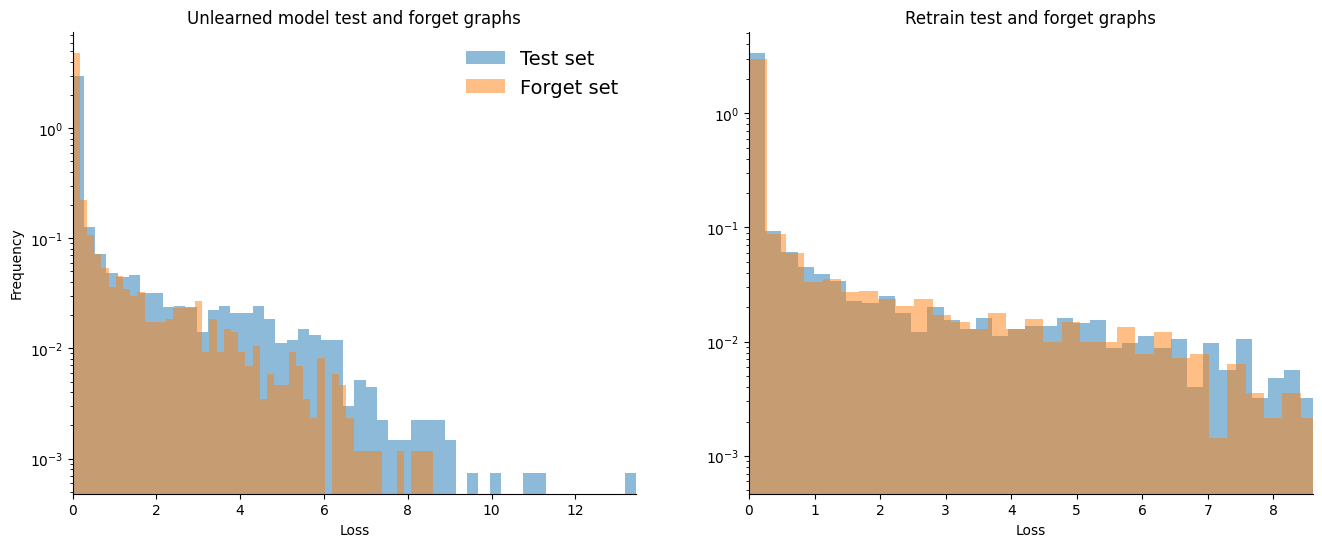

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Unlearned model test and forget graphs")
ax1.hist(ut_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(ut_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(
    f"Retrain test and forget graphs"
)
ax2.hist(rt_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(rt_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(ut_test_losses)))
ax2.set_xlim((0, np.max(ut_forget_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()

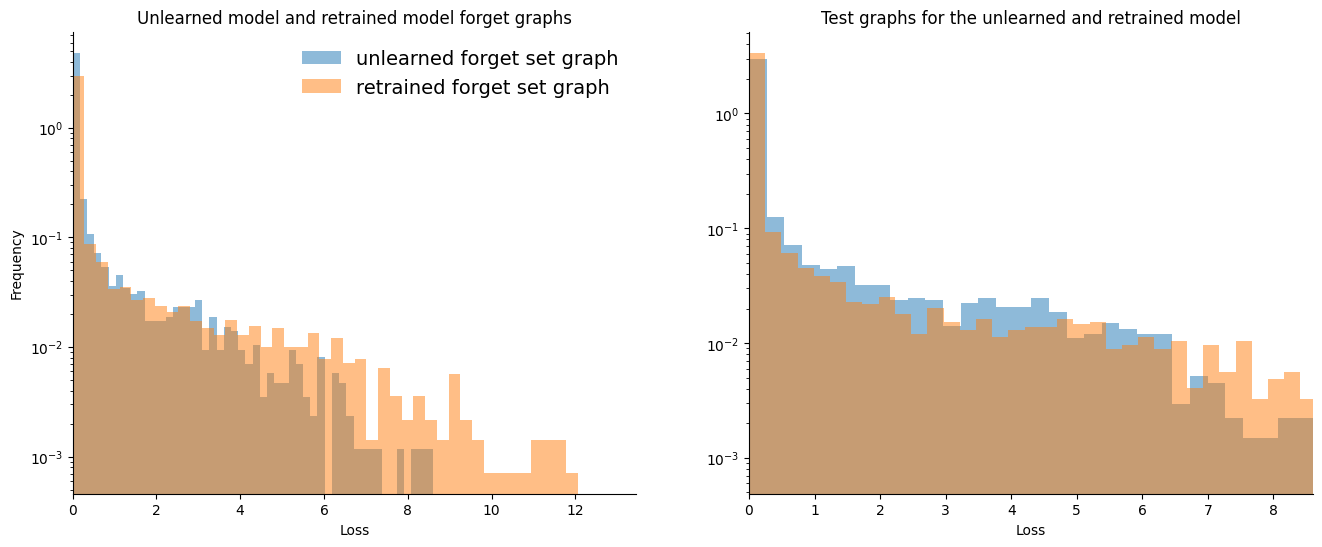

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Unlearned model and retrained model forget graphs")
ax1.hist(ut_forget_losses, density=True, alpha=0.5, bins=50, label="unlearned forget set graph")
ax1.hist(rt_forget_losses, density=True, alpha=0.5, bins=50, label="retrained forget set graph")

ax2.set_title(
    f"Test graphs for the unlearned and retrained model"
)
ax2.hist(ut_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(rt_test_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(ut_test_losses)))
ax2.set_xlim((0, np.max(ut_forget_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()